In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, jarque_bera, norm, chi2, kstest, t
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel('/Users/gaelchen/Desktop/Coursework/RAQ1.xlsx')
df.set_index('Date', inplace=True, drop=True)
df = df.sort_index(ascending=True)

In [3]:
df_log_returns = np.log(df / df.shift(1)).dropna()
weights = np.ones(df_log_returns.shape[1]) / df_log_returns.shape[1]  # 1/6 
df['Daily Portfolio Return'] = df_log_returns.dot(weights)

In [4]:
mean_return = df['Daily Portfolio Return'].dropna().mean()
std_return = df['Daily Portfolio Return'].dropna().std()
df['Standardized Daily Return'] = (df['Daily Portfolio Return'].dropna() - mean_return) / std_return

kurtosis_return = kurtosis(df['Daily Portfolio Return'].dropna(), fisher=True)  # Fisher=True returns the excess kurtosis
skewness_return = skew(df['Daily Portfolio Return'].dropna())

jb_value, jb_p_value = jarque_bera(df['Standardized Daily Return'].dropna())

print("Mean of Daily Returns:", mean_return)
print("Standard Deviation of Daily Returns:", std_return)
print("Kurtosis of Daily Returns:", kurtosis_return)
print("Skewness of Daily Returns:", skewness_return)
print("Jarque-Bera statistic:", jb_value, "with p-value:", jb_p_value)

Mean of Daily Returns: 0.0009197966517384586
Standard Deviation of Daily Returns: 0.015085470295861847
Kurtosis of Daily Returns: 5.771283654885725
Skewness of Daily Returns: -0.4400478018729525
Jarque-Bera statistic: 3930.8233402406186 with p-value: 0.0


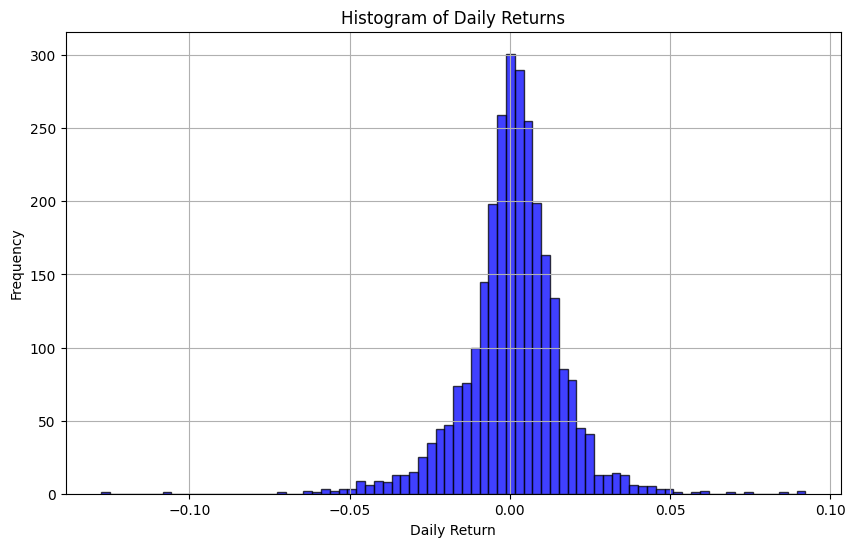

In [5]:
#Original plot
plt.figure(figsize=(10, 6))
plt.hist(df['Daily Portfolio Return'], bins=80, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

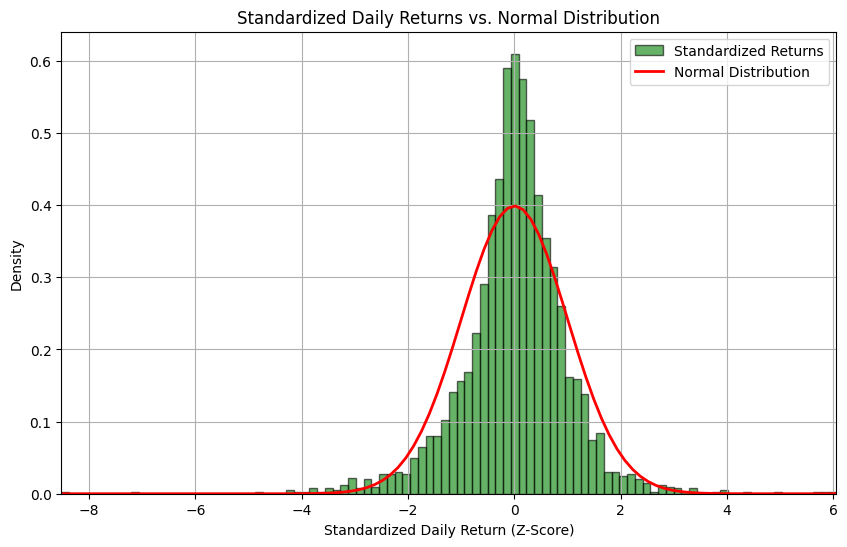

In [6]:
#Standardised Histogram Plot
plt.figure(figsize=(10, 6))

count, bins, ignored = plt.hist(df['Standardized Daily Return'], bins=100, density=True, alpha=0.6, color='green', edgecolor='black', label='Standardized Returns')

x_axis = np.linspace(min(bins), max(bins), 100)

pdf = norm.pdf(x_axis)

plt.plot(x_axis, pdf, color='red', linewidth=2, label='Normal Distribution')

plt.xlim([min(bins), max(bins)])

plt.xlabel('Standardized Daily Return (Z-Score)')
plt.ylabel('Density')
plt.title('Standardized Daily Returns vs. Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#Approach 1: Top-down Approach
def calculate_parametric_var(returns, window_size=124, confidence_level=0):
    """
    Calculate rolling parametric VaR for specified confidence levels.
    """
    rolling_mean = returns.rolling(window=window_size, min_periods=window_size).mean()
    rolling_std = returns.rolling(window=window_size, min_periods=window_size).std()
    alpha = 1 - confidence_level 
    z_score = norm.ppf(alpha)
    
    var = -(rolling_mean + z_score * rolling_std)
    return var

df['AP1_VaR_90'] = calculate_parametric_var(df['Daily Portfolio Return'], confidence_level=0.9)  # For 90% confidence level
df['AP1_VaR_99'] = calculate_parametric_var(df['Daily Portfolio Return'], confidence_level=0.99)  # For 99% confidence level

In [9]:
#Approach 1: t-distribution
def calculate_t_var(returns, window_size=124, confidence_level=0.9, dof=10):

    rolling_mean = returns.rolling(window=window_size, min_periods=window_size).mean()
    rolling_std = returns.rolling(window=window_size, min_periods=window_size).std()
    alpha = 1 - confidence_level
  
    t_score = t.ppf(alpha, df=dof)
    
    var = -(rolling_mean + t_score * rolling_std)
    return var

# Apply the function to the daily portfolio returns
df['AP1t_VaR_90'] = calculate_t_var(df['Daily Portfolio Return'], confidence_level=0.9, dof=10)
df['AP1t_VaR_99'] = calculate_t_var(df['Daily Portfolio Return'], confidence_level=0.99, dof=10)

In [16]:
#Approach 1: Delta-Gamma Approach
def calculate_delta_gamma_var(returns, confidence_level=0.9, window=124, portfolio_value=1.0):
    """
    Calculate Value at Risk using Delta-Gamma approach with Cornish-Fisher expansion
    """
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(alpha)
    
    # Initialize an empty series for Delta-Gamma VaR
    var_series = pd.Series(index=returns.index)
    
    # For each window period
    for i in range(window, len(returns)):
        # Get return data for this window
        window_returns = returns.iloc[i-window:i]
        
        # Calculate moments
        mean = window_returns.mean()
        variance = window_returns.var()
        skew = stats.skew(window_returns)
        kurtosis = stats.kurtosis(window_returns, fisher=True)  # Excess kurtosis
        
        # Calculate Cornish-Fisher adjustment to z-score
        # This accounts for skewness and kurtosis (non-normality)
        z_cf = z_score + \
              (z_score**2 - 1) * skew / 6 + \
              (z_score**3 - 3*z_score) * kurtosis / 24 - \
              (2*z_score**3 - 5*z_score) * skew**2 / 36
        
        # Calculate adjusted VaR
        var_value = -(mean + z_cf * np.sqrt(variance))
        var_series.iloc[i] = var_value
    
    # Convert to absolute currency value if needed
    if portfolio_value != 1.0:
        var_series = var_series * portfolio_value
    
    return var_series

# Adding VaR measures to dataframe
df['AP1B_VaR_90'] = calculate_delta_gamma_var(df['Daily Portfolio Return'], confidence_level=0.9)
df['AP1B_VaR_99'] = calculate_delta_gamma_var(df['Daily Portfolio Return'], confidence_level=0.99)


In [ ]:
#Approach 2: Bootstrapping

def daily_bootstrap_var(returns, window_size=124, confidence_level=0, iterations=1000):


    var_series = pd.Series(np.nan, index=returns.index)
    var_bs_series = pd.Series(np.nan)
    percentile = 1 - confidence_level

    for i in range(window_size, len(returns)):
        bootsum = 0
        windowed_returns = returns[i - window_size:i]
        for j in range(iterations):
            bootstrap_samples = np.random.choice(windowed_returns, size=124, replace=True)
            bootsum = bootsum + np.percentile(bootstrap_samples, percentile * 100)
        var_series[i] = -bootsum/iterations

    return var_series


df['AP2_VaR_90'] = daily_bootstrap_var(df['Daily Portfolio Return'], confidence_level=0.90)
df['AP2_VaR_99'] = daily_bootstrap_var(df['Daily Portfolio Return'], confidence_level=0.99)

/var/folders/ns/vr7jwh6n5_qg5l_8q9lqjwq40000gn/T/ipykernel_9130/1000811367.py:16: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  var_series[i] = -bootsum/iterations


In [ ]:
df[df.index >= '2014-07-01']

In [11]:
#Aproach 3B: Monte Carlo Simulation (Bottom-up approach) with Risk Metrics

lambda_ = 0.94  # EWMA decay factor

def monte_carlo_varB(log_returns, weights, window_size=124, confidence_level=0.10, simulations=5000, lambda_=0.94):
    var_series = pd.Series(np.nan, index=log_returns.index)
    for t in range(window_size, len(log_returns)):

        window_returns = log_returns.iloc[t-window_size:t]
        mean_vector = window_returns.mean()
        
        cov_matrix = window_returns.ewm(span=window_size, adjust=False, min_periods=window_size).cov().iloc[-6:, -6:]
        
        simulated_returns = np.random.multivariate_normal(mean_vector, cov_matrix, simulations)
        
        portfolio_returns = np.log(np.sum(np.exp(simulated_returns) * weights, axis=1))
        
        percentile = 1 - confidence_level
        var_value = -np.percentile(portfolio_returns, (percentile)*100)
        var_series.iloc[t] = var_value
    return var_series

# Calculate VaR for 90% and 99% Confidence Levels
df['AP3_VaR_90'] = monte_carlo_varB(df_log_returns, weights, window_size=124, confidence_level=0.90, simulations=2000, lambda_=0.94)
df['AP3_VaR_99'] = monte_carlo_varB(df_log_returns, weights, window_size=124, confidence_level=0.99, simulations=2000, lambda_=0.94)


In [17]:
#Aproach 4B: Bottom-up approach with Taylor Approximation and Risk Metrics to calculate the COV

lambda_ = 0.94  # EWMA decay factor for RiskMetrics

def analytical_var(log_returns, weights, window_size=124, confidence_level=0.99):
    var_series = pd.Series(np.nan, index=log_returns.index)
    alpha = 1 - confidence_level
    z_score = norm.ppf(alpha) 
    for t in range(window_size, len(log_returns)):
        window_returns = log_returns.iloc[t-window_size:t]
        
        mean_vector = window_returns.mean()

        cov_matrix = window_returns.ewm(span=window_size, adjust=False, min_periods=window_size).cov().iloc[-6:, -6:]
        
        
        portfolio_mean = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        var_value = -(portfolio_mean + z_score * portfolio_std)
        var_series.iloc[t] = var_value
    return var_series


df['AP4_VaR_90'] = analytical_var(df_log_returns, weights, window_size=124, confidence_level=0.90)
df['AP4_VaR_99'] = analytical_var(df_log_returns, weights, window_size=124, confidence_level=0.99)


KeyError: 'AP3B_VaR_90'

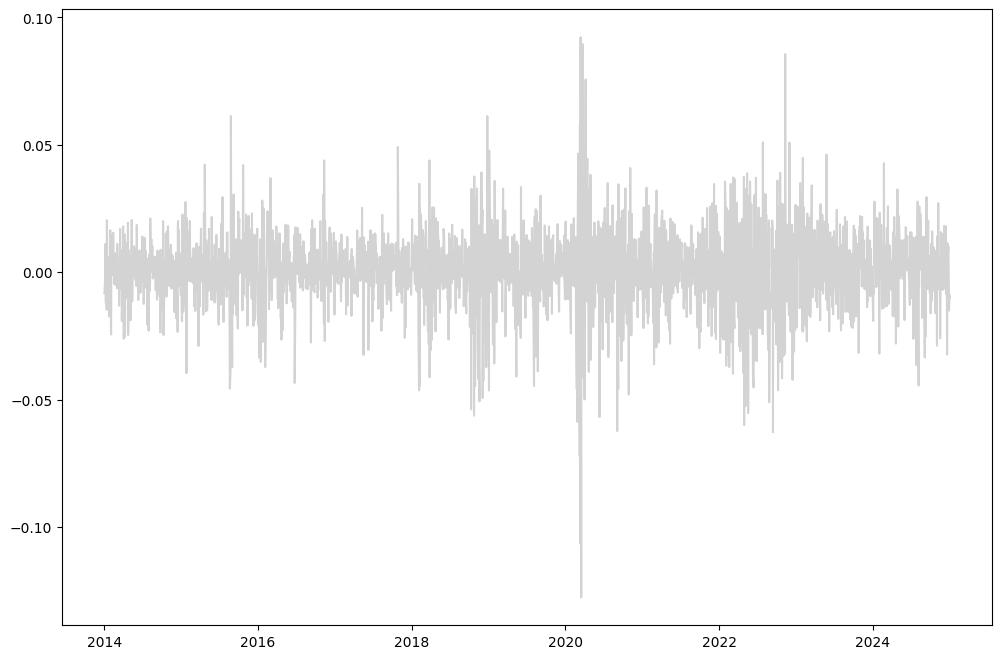

In [14]:
# Assuming df is your DataFrame containing the necessary columns
plt.figure(figsize=(12, 8))

# Plotting Daily Portfolio Return in red
plt.plot(df.index, df['Daily Portfolio Return'], color='lightgrey', label='Daily Portfolio Return')

# Plotting AP1_VaR_90 in blue dotted line
plt.plot(df.index, -df['AP3_VaR_90'], 'b--', label='AP3 VaR 90%')

# Plotting AP1_VaR_99 in green dotted line
plt.plot(df.index, -df['AP3_VaR_99'], 'g--', label='AP3 VaR 99%')

# Adding title and labels
plt.title('Daily Portfolio Returns and Value at Risk (VaR) Levels')
plt.xlabel('Date')
plt.ylabel('Returns / VaR')

# Adding a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [ ]:
# It is the kupiec test based on the textbook 

def kupiec_test(actual_returns, var_column, var_confidence_level=0.90):

    actual_returns = actual_returns[actual_returns.index >= '2014-07-01']
    var_column = var_column[var_column.index >='2014-07-01']
    
    print(f'Running Kupiec Test with VaR column: {var_column.name} and confidence level: {var_confidence_level}')


    p = 1 - var_confidence_level


    violations = (actual_returns.shift(-1) < -var_column).astype(int)
    T1 = violations.sum() 
    T0 = len(violations) - T1 
    
    # Calculate observed violation rate
    pi_hat = T1 / len(violations) if len(violations) > 0 else 0

    # Calculate likelihoods
    L_p = (1-p)**T0 * (p)**T1 if p > 0 and T1 > 0 else np.nextafter(0, 1) 
    L_pi_hat = (1 - pi_hat)**T0 * pi_hat**T1 if pi_hat > 0 and T0 > 0 else np.nextafter(0, 1)

    # Calculate the likelihood ratio test statistic, checking for valid values
    if L_p > 0 and L_pi_hat > 0:
        LR_uc = -2 * np.log(L_p / L_pi_hat)
    else:
        LR_uc = 0

    p_value = 1 - chi2.cdf(LR_uc, df=1) 

    

    print(f'Total Violations: {T1}')
    print(f'Total Non-Violations: {T0}')
    print(f'Violation Rate : {pi_hat}')
    print(f'Test Statistic (LR_uc): {LR_uc}')
    print(f'P-value: {p_value}')
 
    if p_value < 0.05 and not np.isnan(p_value):
        print("Result: Null hypothesis is rejected (indicating a poor fit of the VaR model at the specified confidence level).")
    else:
        print("Result: Null hypothesis is not rejected (indicating an adequate fit of the VaR model at the specified confidence level).")

kupiec_test(df['Daily Portfolio Return'], df['AP1_t_VaR_90'],0.90)
print('---------------------------------------------------')
kupiec_test(df['Daily Portfolio Return'], df['AP1_t_VaR_99'],0.99)
print('---------------------------------------------------')
kupiec_test(df['Daily Portfolio Return'], df['AP1_VaR_90'],0.90)
print('---------------------------------------------------')
kupiec_test(df['Daily Portfolio Return'], df['AP1_VaR_99'],0.99)
print('---------------------------------------------------')


In [15]:
# Adjusted code to deal with the nan value for 90% VaR

def kupiec_test_simp(VaR_failures, total_obs, alpha):

    p_hat = VaR_failures / total_obs
    p = 1 - alpha

    epsilon = 1e-10  # Small constant to prevent log(0)
    p_hat = np.clip(p_hat, epsilon, 1 - epsilon)
    p = np.clip(p, epsilon, 1 - epsilon)

    LR_stat = -2 * (
        (total_obs - VaR_failures) * np.log((1 - p) / (1 - p_hat)) +
        VaR_failures * np.log(p / p_hat)
    )

    p_value = 1 - stats.chi2.cdf(LR_stat, df=1)

    return {"LR_stat": LR_stat, "p_value": p_value}

# Adjust the values for the test
VaR_failures = 182
VaR_success = 2094
alpha = 0.90  
total_obs = VaR_failures + VaR_success 

result = kupiec_test_simp(VaR_failures, total_obs, alpha)
print(f"LR Statistic: {result['LR_stat']:.4f}, p-value: {result['p_value']:.4f}")

LR Statistic: 10.8234, p-value: 0.0010


In [19]:
def christoffersen_conditional_test(actual_returns, var_column, var_confidence_level):
 
 
    p = 1 - var_confidence_level  

    violations = (actual_returns.shift(-1) < -var_column).astype(int)

    T00 = ((violations.shift(1) == 0) & (violations == 0)).sum()
    T01 = ((violations.shift(1) == 0) & (violations == 1)).sum()
    T10 = ((violations.shift(1) == 1) & (violations == 0)).sum()
    T11 = ((violations.shift(1) == 1) & (violations == 1)).sum()

    T1 = T01 + T11 
    T0 = T00 + T10  

    epsilon = 1e-10
    pi_01_hat = T01 / (T00 + T01 + epsilon)
    pi_11_hat = T11 / (T10 + T11 + epsilon)
    p_hat = (T01 + T11) / (T0 + T1 + epsilon) 

    logL_indep = (T0 * np.log(1 - p_hat + epsilon) + T1 * np.log(p_hat + epsilon))
    logL_cond = (T00 * np.log(1 - pi_01_hat + epsilon) + 
                 T01 * np.log(pi_01_hat + epsilon) + 
                 T10 * np.log(1 - pi_11_hat + epsilon) + 
                 T11 * np.log(pi_11_hat + epsilon))

    LR_cc = -2 * (logL_indep - logL_cond)

    p_value = 1 - stats.chi2.cdf(LR_cc, df=1)
      

    print(f'Total Violations: {T1}')
    print(f'Total Non-Violations: {T0}')
    print(f'Test Statistic: {LR_cc}')
    print(f'P-value: {p_value}')
 
    if p_value < 0.05 and not np.isnan(p_value):
        print("Result: Null hypothesis is rejected (indicating a poor fit of the VaR model at the specified confidence level).")
    else:
        print("Result: Null hypothesis is not rejected (indicating an adequate fit of the VaR model at the specified confidence level).")
    return

christoffersen_conditional_test(df['Daily Portfolio Return'], df['AP1_t_VaR_90'],0.90)


Total Violations: 222
Total Non-Violations: 2546
Test Statistic: 4.970298504801349
P-value: 0.025786196831555475
Result: Null hypothesis is rejected (indicating a poor fit of the VaR model at the specified confidence level).


In [87]:
window_size = 124

# Calculate rolling mean and standard deviation
df['mean_window'] = df['Daily Portfolio Return'].rolling(window=window_size).mean()
df['std_window'] = df['Daily Portfolio Return'].rolling(window=window_size).std()

# Calculate the transformed probabilities for each day
# Using the rolling mean and standard deviation
df['Transformed Probability'] = df.apply(
    lambda row: norm.cdf(row['Daily Portfolio Return'], loc=row['mean_window'], scale=row['std_window']),
    axis=1
)

# Drop any rows where the mean or standard deviation could not be computed (i.e., the first 123 days)
df.dropna(subset=['mean_window', 'std_window', 'Transformed Probability'], inplace=True)

# Optionally, you can view or export the data
print(df[['Daily Portfolio Return', 'mean_window', 'std_window', 'Transformed Probability']])

            Daily Portfolio Return  mean_window  std_window  \
Date                                                          
2017-11-29               -0.025762     0.000941    0.009743   
2017-11-30                0.010035     0.001040    0.009773   
2017-12-01               -0.006129     0.000965    0.009792   
2017-12-04               -0.021657     0.000694    0.009949   
2017-12-05                0.003047     0.000965    0.009542   
...                            ...          ...         ...   
2024-12-24                0.010156     0.001099    0.013317   
2024-12-26               -0.001820     0.000958    0.013255   
2024-12-27               -0.015094     0.000773    0.013318   
2024-12-30               -0.008922     0.000653    0.013338   
2024-12-31               -0.009879     0.000498    0.013348   

            Transformed Probability  
Date                                 
2017-11-29                 0.003066  
2017-11-30                 0.821311  
2017-12-01                 0

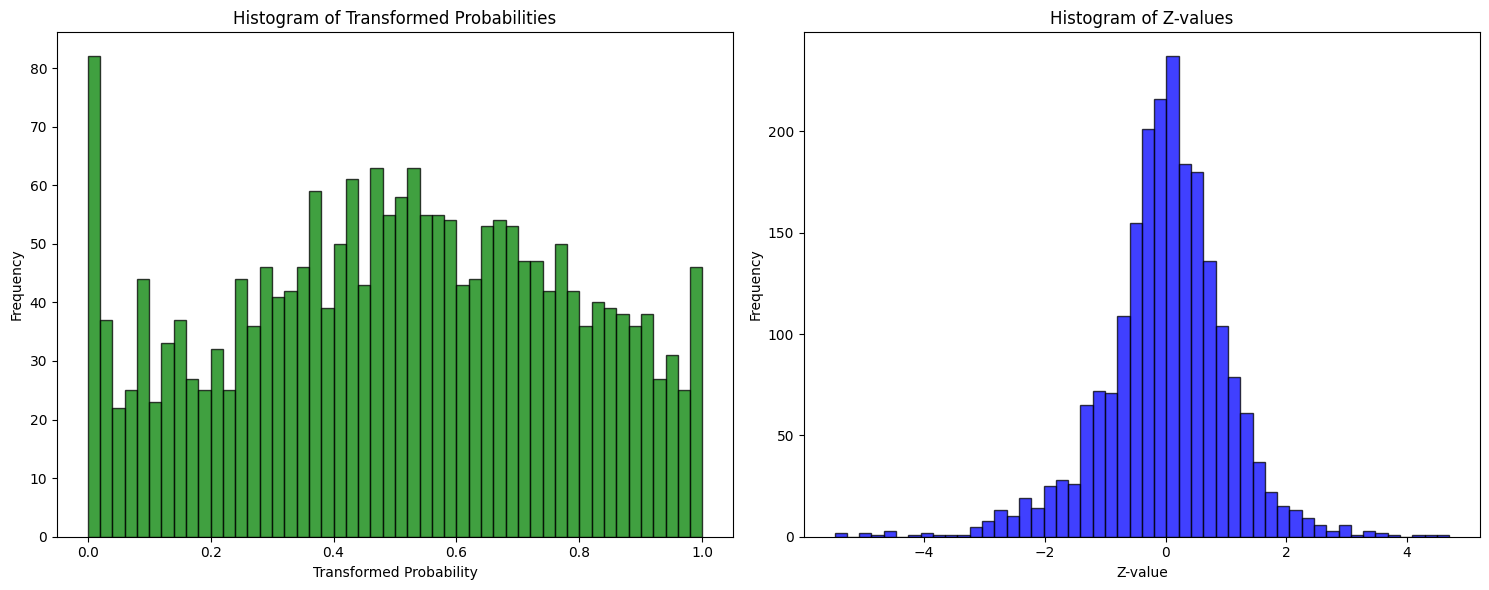

In [84]:
df['Z-values'] = norm.ppf(df['Transformed Probability'])

# Plotting
plt.figure(figsize=(15, 6))

# Histogram of Transformed Probabilities
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(df['Transformed Probability'], bins=50, color='green', alpha=0.75, edgecolor='black')
plt.title('Histogram of Transformed Probabilities')
plt.xlabel('Transformed Probability')
plt.ylabel('Frequency')

# Histogram of Z-values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(df['Z-values'], bins=50, color='blue', alpha=0.75, edgecolor='black')
plt.title('Histogram of Z-values')
plt.xlabel('Z-value')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust the layout to make room for the plots
plt.show()

In [96]:


# Calculate transformed probabilities using the t-distribution
df['Transformed Probability t'] = df.apply(
    lambda row: t.cdf(row['Daily Portfolio Return'], df=row['df_window'], loc=row['mean_window'], scale=row['std_window'])
    if not pd.isna(row['mean_window']) and not pd.isna(row['std_window']) else np.nan,
    axis=1
)

# Drop any rows where values couldn't be computed (i.e., the first 123 rows)
df.dropna(subset=['mean_window', 'std_window', 'Transformed Probability'], inplace=True)

# Optionally, you can view the results
print(df[['Transformed Probability']])

            Transformed Probability
Date                               
2018-11-23                 0.294294
2018-11-26                 0.980839
2018-11-27                 0.560897
2018-11-28                 0.991894
2018-11-29                 0.342728
...                             ...
2024-12-24                 0.753543
2024-12-26                 0.413808
2024-12-27                 0.116373
2024-12-30                 0.235362
2024-12-31                 0.217112

[1535 rows x 1 columns]


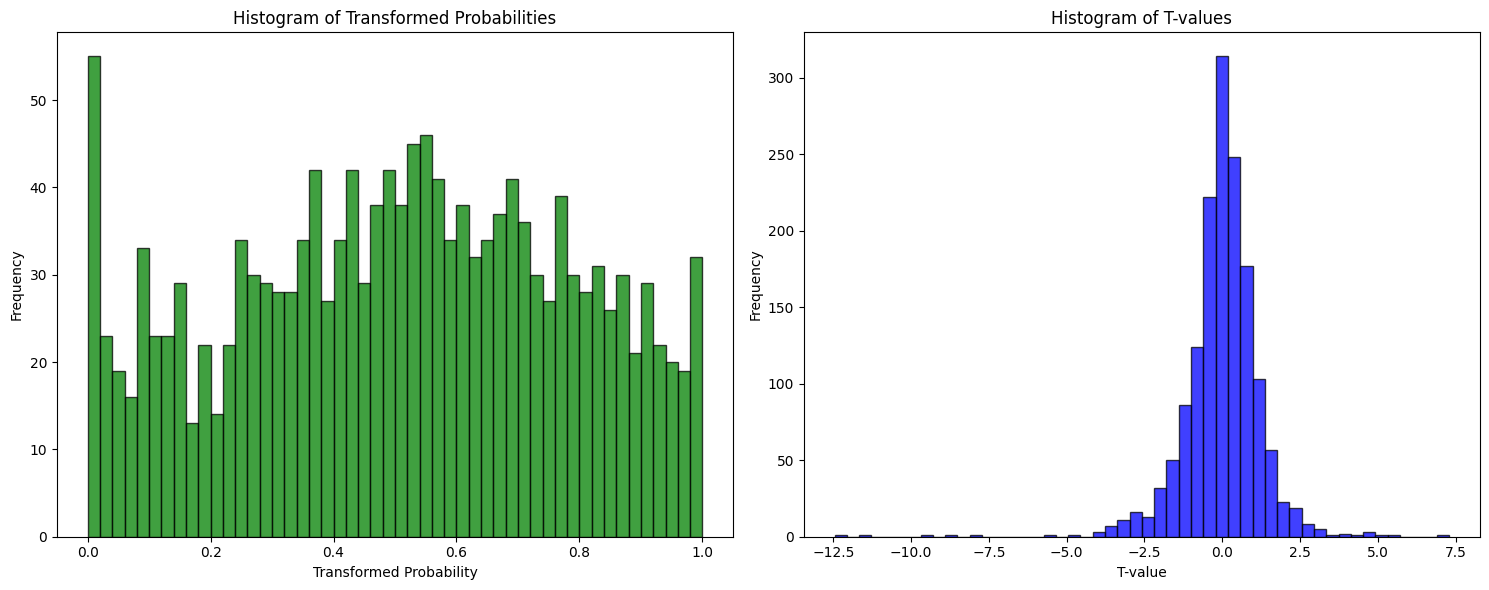

In [98]:
df['T-values'] = t.ppf(df['Transformed Probability t'], df=10)
# Plotting
plt.figure(figsize=(15, 6))

# Histogram of Transformed Probabilities
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(df['Transformed Probability'], bins=50, color='green', alpha=0.75, edgecolor='black')
plt.title('Histogram of Transformed Probabilities')
plt.xlabel('Transformed Probability')
plt.ylabel('Frequency')

# Histogram of Z-values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(df['T-values'], bins=50, color='blue', alpha=0.75, edgecolor='black')
plt.title('Histogram of T-values')
plt.xlabel('T-value')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust the layout to make room for the plots
plt.show()